**1. Load Libraries and Path**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import xgboost as xgb
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [ ]:
FOLDER_PATH = '/content/drive/MyDrive/final_project/data'

TRAINING_DATA_PATH = os.path.join(FOLDER_PATH, 'preprocessed_train.csv')
VALID_DATA_PATH    = os.path.join(FOLDER_PATH, 'preprocessed_valid.csv')
TEST_DATA_PATH     = os.path.join(FOLDER_PATH, 'preprocessed_test.csv')

**2. Load Data**

In [ ]:
train_df = pd.read_csv(TRAINING_DATA_PATH)
print(f"train shape : {train_df.shape}")

valid_df = pd.read_csv(VALID_DATA_PATH)
print(f"train shape : {valid_df.shape}")

test_df = pd.read_csv(TEST_DATA_PATH)
print(f"train shape : {test_df.shape}")

train shape : (35986, 3)
train shape : (5125, 3)
train shape : (10159, 3)


**3. Feature Encoding**

*3.1 Count Vectorizer*

In [ ]:
## setting count vectorizer encoder
encoder_count = CountVectorizer(analyzer='word',
                                ngram_range=(1, 3), 
                                stop_words="english",
                                min_df = 10,
                                max_df = 0.95)

## train model
encoder_count.fit(train_df["text_preprocessed"])

## transforming data
X_train_count =  encoder_count.transform(train_df["text_preprocessed"])
X_valid_count =  encoder_count.transform(valid_df["text_preprocessed"])
X_test_count  =  encoder_count.transform(test_df["text_preprocessed"])

## get shape
X_train_count.shape, X_valid_count.shape, X_test_count.shape

((35986, 141451), (5125, 141451), (10159, 141451))

*3.2 Tfidf Vectorizer*

In [ ]:
## setting tfidf vectorizer encoder
encoder_tfidf = TfidfVectorizer(analyzer='word',
                                ngram_range=(1, 3), 
                                stop_words="english",
                                min_df = 10,
                                max_df = 0.95)

## train model
encoder_tfidf.fit(train_df["text_preprocessed"])

## transforming data
X_train_tfidf =  encoder_tfidf.transform(train_df["text_preprocessed"])
X_valid_tfidf =  encoder_tfidf.transform(valid_df["text_preprocessed"])
X_test_tfidf  =  encoder_tfidf.transform(test_df["text_preprocessed"])

## get shape
X_train_tfidf.shape, X_valid_tfidf.shape, X_test_tfidf.shape

((35986, 141451), (5125, 141451), (10159, 141451))

In [ ]:
## get outputs
Y_train = train_df['propaganda_label']
Y_valid = valid_df['propaganda_label']
Y_test  = test_df['propaganda_label']

Y_train.shape, Y_valid.shape, Y_test.shape

((35986,), (5125,), (10159,))

**4. Feature Selection Using KBest Method**

*Univariate feature selection works by selecting the best features based on univariate statistical tests. The statistical test which is going to be used for univariate feature selection is 'chi square test'.*

*4.1 Count Vectorizer*

In [ ]:
## selecting total 100 features as the optimal features
## it can be any number based on the intution we can select
n_features = 100

## model object to get best features
encoder_fs = SelectKBest(chi2, k = n_features)

## training and get best columns
encoder_fs.fit(X_train_count, Y_train)

## transform data and convert into dframe
X_train_count_fs = encoder_fs.transform(X_train_count)
X_valid_count_fs = encoder_fs.transform(X_valid_count)
X_test_count_fs = encoder_fs.transform(X_test_count)

X_train_count_fs.shape, X_valid_count_fs.shape, X_test_count_fs.shape

((35986, 100), (5125, 100), (10159, 100))

*4.2 Tfidf Vectorizer*

In [ ]:
## selecting total 100 features as the optimal features
## it can be any number based on the intution we can select
n_features = 100

## model object to get best features
encoder_fs1 = SelectKBest(chi2, k = n_features)

## training and get best columns
encoder_fs1.fit(X_train_tfidf, Y_train)

## transform data and convert into dframe
X_train_tfidf_fs = encoder_fs1.transform(X_train_tfidf)
X_valid_tfidf_fs = encoder_fs1.transform(X_valid_tfidf)
X_test_tfidf_fs = encoder_fs1.transform(X_test_tfidf)

X_train_tfidf_fs.shape, X_valid_tfidf_fs.shape, X_test_tfidf_fs.shape

((35986, 100), (5125, 100), (10159, 100))

**5. Functions to be used**

In [ ]:
## https://stackoverflow.com/questions/48586022/how-to-perform-stratifiedshufflesplit-in-gridsearchcv
def hyper_parameter_tuning(model_name, model, parameter_list, train_input, test_input,
                           train_output, test_output,random=False):
    
    print(f"Trained started for : {model_name}")
    if random == True:
        model_tuning = RandomizedSearchCV(model, parameter_list, verbose=1, n_jobs=-1,
                                          cv=5, scoring = 'recall')
    else:
        model_tuning = GridSearchCV(model,parameter_list,verbose=1, n_jobs=-1,
                                    cv=5, scoring = 'recall')
    model_tuning.fit(train_input, train_output)
    print(f"Best Parameters:{model_tuning.best_params_}")
    print(f"Best Recall Score : {model_tuning.best_score_:.2f}\n")
    
    ## training on best estimator
    model_final = model_tuning.best_estimator_
    model_final.fit(train_input, train_output)
    
    ## get scores
    scores = get_scores(model_final, model_name, train_input, test_input,
                        train_output, test_output)
    
    return model_final, scores

In [ ]:
def get_scores(model, model_name, xtrain, xtest, ytrain, ytest):
    
    ## empty list to append scores
    scores = {}
    
    ## predicted class values
    class0_total = ytest.value_counts().values[0]
    class1_total = ytest.value_counts().values[1]
    
    ## prediction on train and test data
    ytrain_pred = model.predict(xtrain)
    ytrain_pred_proba = model.predict_proba(xtrain)
    ytest_pred = model.predict(xtest)
    ytest_pred_proba = model.predict_proba(xtest)
    
    ## confusion matrix output
    class0_pred = metrics.confusion_matrix(ytest, ytest_pred)[0][0]
    class1_pred = metrics.confusion_matrix(ytest, ytest_pred)[1][1]
    
    ## get individual accuracy score
    not_propaganda_acc = round((class0_pred/class0_total), 4)
    propaganda_acc    = round((class1_pred/class1_total), 4)
    
    ## get prediction
    train_acc = float("{:.4f}".format(metrics.accuracy_score(ytrain, ytrain_pred)))
    test_acc = float("{:.4f}".format(metrics.accuracy_score(ytest, ytest_pred)))
    test_f1 = float("{:.4f}".format(metrics.f1_score(ytest, ytest_pred)))
    test_precision = float("{:.4f}".format(metrics.precision_score(ytest, ytest_pred)))
    test_recall = float("{:.4f}".format(metrics.recall_score(ytest, ytest_pred)))
    test_roc_score = float("{:.4f}".format(metrics.roc_auc_score(ytest, ytest_pred)))
    
    ## get roc auc scores
    fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(ytrain,  ytrain_pred_proba[:, 1])
    auc_train = round(metrics.auc(fpr_tr, tpr_tr), 4)
    fpr_te, tpr_te, threshold_te = metrics.roc_curve(ytest,  ytest_pred_proba[:,1])
    auc_test = round(metrics.auc(fpr_te, tpr_te), 4)
    
    scores['model_name'] = model_name
    scores['accuracy'] = test_acc
    scores['auc'] = auc_test
    scores['not_propaganda_accuracy'] = not_propaganda_acc
    scores['propaganda_accuracy'] = propaganda_acc
    scores['f1'] = test_f1
    scores['precision'] = test_precision
    scores['recall'] = test_recall
    scores['roc'] = test_roc_score
    
    return scores

In [ ]:
def get_plots(ytrain, ytest, ytrain_proba, ytest_proba, ytrain_pred, ytest_pred):
    """
    This function generates roc_auc_curve and confusion matrix.
    """
    class_report = metrics.classification_report(ytest, ytest_pred)
    print("-------------------------------------Classification Report---------------------------------------")
    print(class_report)
    
    fig = plt.figure(figsize=(15,10))
    
    ## generate tpr, fpr scores for different threshold of probability
    ## for roc auc curve
    fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(ytrain, ytrain_proba[:, 1])
    fpr_te, tpr_te, threshold_te = metrics.roc_curve(ytest, ytest_proba[:,1])
    
    ## get auc score
    auc_train = metrics.auc(fpr_tr, tpr_tr)
    auc_test = metrics.auc(fpr_te, tpr_te)
    
    ## plot roc curves
    plt.subplot(221)
    plt.plot(fpr_tr, tpr_tr, label = "train auc - " + str(round(auc_train,2)))
    plt.plot(fpr_te, tpr_te, label = "test auc - "  + str(round(auc_test ,2)))
    plt.legend()
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.title('ROC Curve', fontsize=20)
    
    ## plot roc auc score
    plt.subplot(222)
    conf_matrix = metrics.confusion_matrix(ytest, ytest_pred)
    plot = sns.heatmap(conf_matrix, cbar=False, fmt = '2g', annot=True, cmap = 'Blues')
    plt.title("Confusion Matrix", fontsize=20)
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actuals', fontsize=20)
    
    plt.show()

**6. Machine Learning Modelling For COUNT VECTORIZER & TFIDF VECTORIZER**

**6.1 Gaussian Naive Bayes**

Trained started for : Gaussian Naive Bayes Count
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:{'var_smoothing': 0.0006579332246575676}
Best Recall Score : 0.43

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.94      0.98      0.96      4550
           1       0.80      0.51      0.62       575

    accuracy                           0.93      5125
   macro avg       0.87      0.75      0.79      5125
weighted avg       0.92      0.93      0.92      5125



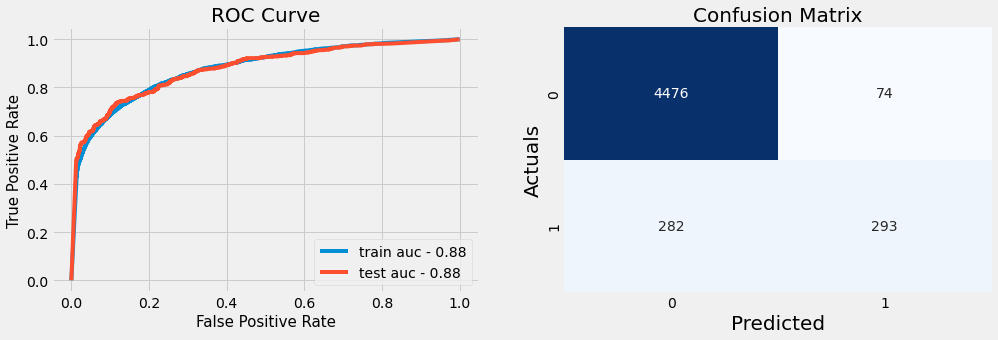

In [ ]:
gnb_list = {"var_smoothing" : np.logspace(0,-9, num=100)}

gnb_model = GaussianNB()

model_gnb, scores_gnb = hyper_parameter_tuning('Gaussian Naive Bayes Count', gnb_model,
                                               gnb_list,
                                               X_train_count_fs.toarray(),
                                               X_valid_count_fs.toarray(),
                                               Y_train, Y_valid,
                                               random=False)

Y_train_proba = model_gnb.predict_proba(X_train_count_fs.toarray())
Y_valid_proba = model_gnb.predict_proba(X_valid_count_fs.toarray())

Y_train_pred = model_gnb.predict(X_train_count_fs.toarray())
Y_valid_pred = model_gnb.predict(X_valid_count_fs.toarray())

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

Trained started for : Gaussian Naive Bayes Tfidf
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:{'var_smoothing': 0.0015199110829529332}
Best Recall Score : 0.43

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.94      0.99      0.96      4550
           1       0.84      0.52      0.64       575

    accuracy                           0.93      5125
   macro avg       0.89      0.75      0.80      5125
weighted avg       0.93      0.93      0.93      5125



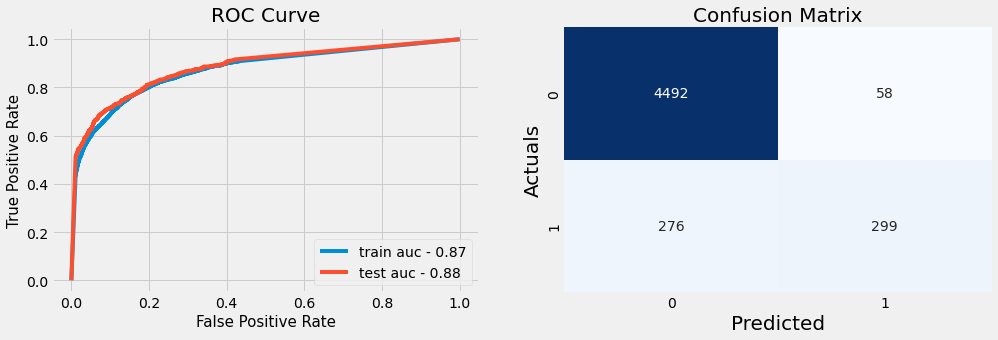

In [ ]:
model_gnb_tfidf, scores_gnb_tfidf = hyper_parameter_tuning('Gaussian Naive Bayes Tfidf', gnb_model,
                                               gnb_list,
                                               X_train_tfidf_fs.toarray(),
                                               X_valid_tfidf_fs.toarray(),
                                               Y_train, Y_valid,
                                               random=False)

Y_train_proba = model_gnb_tfidf.predict_proba(X_train_tfidf_fs.toarray())
Y_valid_proba = model_gnb_tfidf.predict_proba(X_valid_tfidf_fs.toarray())

Y_train_pred = model_gnb_tfidf.predict(X_train_tfidf_fs.toarray())
Y_valid_pred = model_gnb_tfidf.predict(X_valid_tfidf_fs.toarray())

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

**6.2 Bernoulli Naive Bayes**

Trained started for : Bernoulli Naive Bayes Tfidf
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters:{'alpha': 0.0001}
Best Recall Score : 0.32

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.94      0.98      0.96      4550
           1       0.76      0.48      0.59       575

    accuracy                           0.93      5125
   macro avg       0.85      0.73      0.78      5125
weighted avg       0.92      0.93      0.92      5125



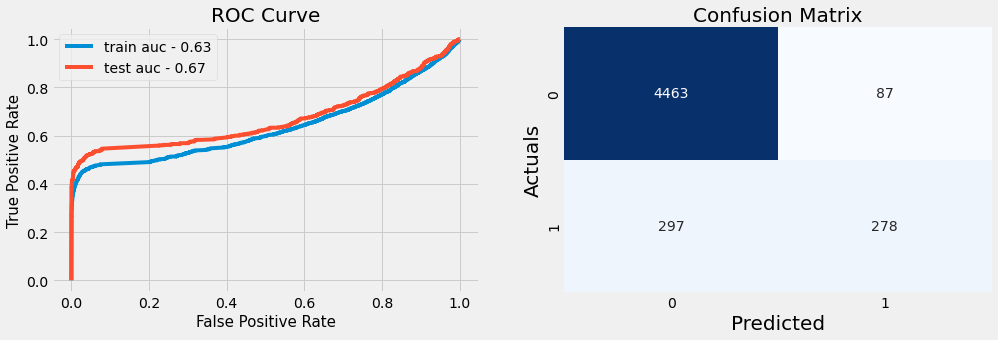

In [ ]:
bnb_list = {"alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

bnb_model = MultinomialNB()

model_bnb, scores_bnb = hyper_parameter_tuning('Bernoulli Naive Bayes Tfidf', bnb_model,
                                               bnb_list,
                                               X_train_count_fs, X_valid_count_fs, 
                                               Y_train, Y_valid,
                                               random=False)

Y_train_proba = model_bnb.predict_proba(X_train_count_fs)
Y_valid_proba = model_bnb.predict_proba(X_valid_count_fs)

Y_train_pred = model_bnb.predict(X_train_count_fs)
Y_valid_pred = model_bnb.predict(X_valid_count_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

Trained started for : Bernoulli Naive Bayes Tfidf
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters:{'alpha': 0.0001}
Best Recall Score : 0.13

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96      4550
           1       0.91      0.37      0.53       575

    accuracy                           0.93      5125
   macro avg       0.92      0.68      0.74      5125
weighted avg       0.92      0.93      0.91      5125



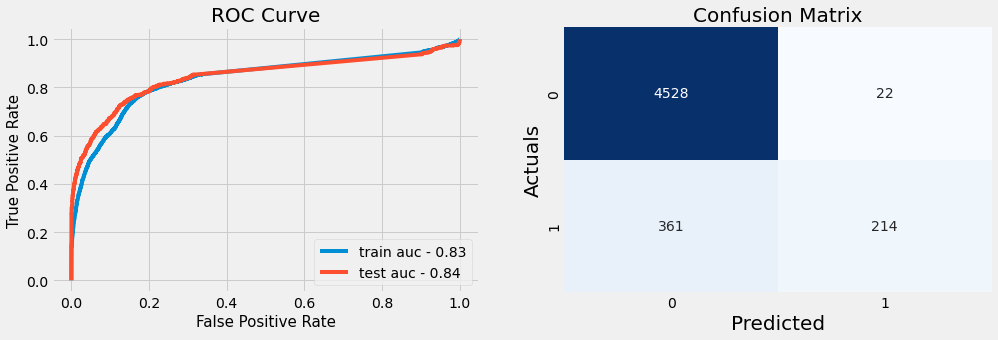

In [ ]:
model_bnb_tfidf, scores_bnb_tfidf = hyper_parameter_tuning('Bernoulli Naive Bayes Tfidf', bnb_model,
                                               bnb_list,
                                               X_train_tfidf_fs, X_valid_tfidf_fs, 
                                               Y_train, Y_valid,
                                               random=False)

Y_train_proba = model_bnb.predict_proba(X_train_tfidf_fs)
Y_valid_proba = model_bnb.predict_proba(X_valid_tfidf_fs)

Y_train_pred = model_bnb.predict(X_train_tfidf_fs)
Y_valid_pred = model_bnb.predict(X_valid_tfidf_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

**6.3 Weighted Logistic Regression**

Trained started for : Weighted Logistic Regression Count
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters:{'C': 100, 'penalty': 'l2'}
Best Recall Score : 0.67

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.96      0.92      0.94      4550
           1       0.53      0.70      0.60       575

    accuracy                           0.90      5125
   macro avg       0.75      0.81      0.77      5125
weighted avg       0.91      0.90      0.90      5125



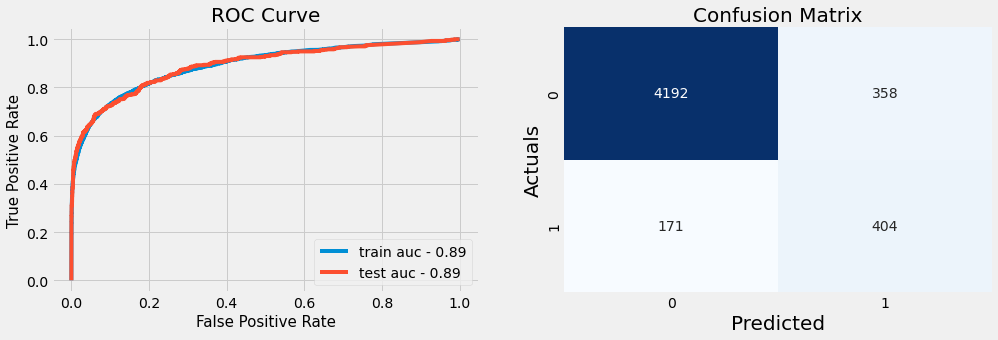

In [ ]:
wlr_list = {'C' : [0.0001, 0.001, 0.05, 0.01, 0.1, 0.5, 1, 10, 100],
            'penalty' : ['l1', 'l2', 'elasticnet', None]}

wlr_model = LogisticRegression(class_weight = 'balanced')

model_wlr, scores_wlr = hyper_parameter_tuning('Weighted Logistic Regression Count', wlr_model,
                                               wlr_list,
                                               X_train_count_fs, X_valid_count_fs, 
                                               Y_train, Y_valid,
                                               random=False)

Y_train_proba = model_wlr.predict_proba(X_train_count_fs)
Y_valid_proba = model_wlr.predict_proba(X_valid_count_fs)

Y_train_pred = model_wlr.predict(X_train_count_fs)
Y_valid_pred = model_wlr.predict(X_valid_count_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

Trained started for : Weighted Logistic Regression Tfidf
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters:{'C': 100, 'penalty': 'l2'}
Best Recall Score : 0.68

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.96      0.91      0.94      4550
           1       0.51      0.73      0.60       575

    accuracy                           0.89      5125
   macro avg       0.74      0.82      0.77      5125
weighted avg       0.91      0.89      0.90      5125



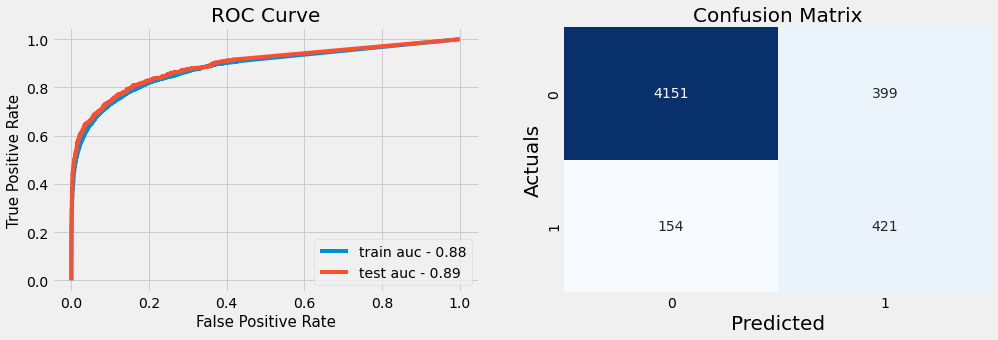

In [ ]:
model_wlr_tfidf, scores_wlr_tfidf = hyper_parameter_tuning('Weighted Logistic Regression Tfidf', wlr_model,
                                                           wlr_list,
                                                           X_train_tfidf_fs, X_valid_tfidf_fs, 
                                                           Y_train, Y_valid,
                                                           random=False)

Y_train_proba = model_wlr_tfidf.predict_proba(X_train_tfidf_fs)
Y_valid_proba = model_wlr_tfidf.predict_proba(X_valid_tfidf_fs)

Y_train_pred = model_wlr_tfidf.predict(X_train_tfidf_fs)
Y_valid_pred = model_wlr_tfidf.predict(X_valid_tfidf_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

**6.4 Non-Weighted Logistic Regression**

Trained started for : Non Weighted Logistic Regression Count
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters:{'C': 100, 'penalty': 'l2'}
Best Recall Score : 0.42

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.94      0.99      0.97      4550
           1       0.88      0.50      0.64       575

    accuracy                           0.94      5125
   macro avg       0.91      0.75      0.80      5125
weighted avg       0.93      0.94      0.93      5125



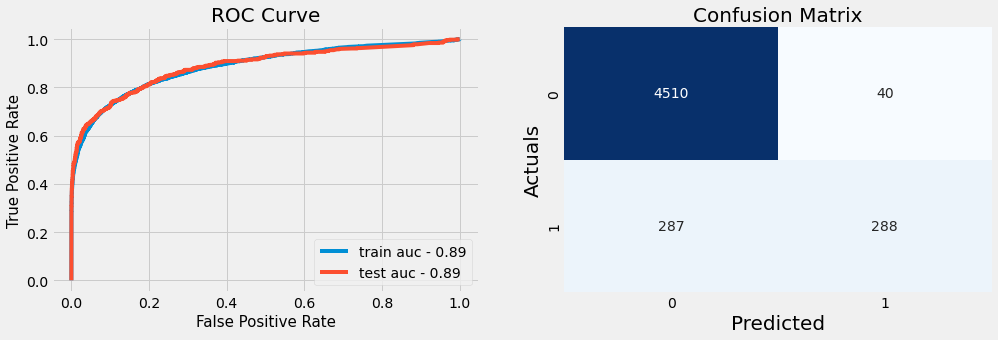

In [ ]:
nwlr_list = {'C' : [0.0001, 0.001, 0.05, 0.01, 0.1, 0.5, 1, 10, 100],
            'penalty' : ['l1', 'l2', 'elasticnet', None]}

nwlr_model = LogisticRegression(class_weight = None)

model_nwlr, scores_nwlr = hyper_parameter_tuning('Non Weighted Logistic Regression Count', nwlr_model,
                                                 nwlr_list,
                                                 X_train_count_fs, X_valid_count_fs, 
                                                 Y_train, Y_valid,
                                                 random=False)

Y_train_proba = model_nwlr.predict_proba(X_train_count_fs)
Y_valid_proba = model_nwlr.predict_proba(X_valid_count_fs)

Y_train_pred = model_nwlr.predict(X_train_count_fs)
Y_valid_pred = model_nwlr.predict(X_valid_count_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

Trained started for : Non Weighted Logistic Regression Tfidf
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters:{'C': 100, 'penalty': 'l2'}
Best Recall Score : 0.41

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.94      0.99      0.97      4550
           1       0.87      0.54      0.67       575

    accuracy                           0.94      5125
   macro avg       0.91      0.77      0.82      5125
weighted avg       0.94      0.94      0.93      5125



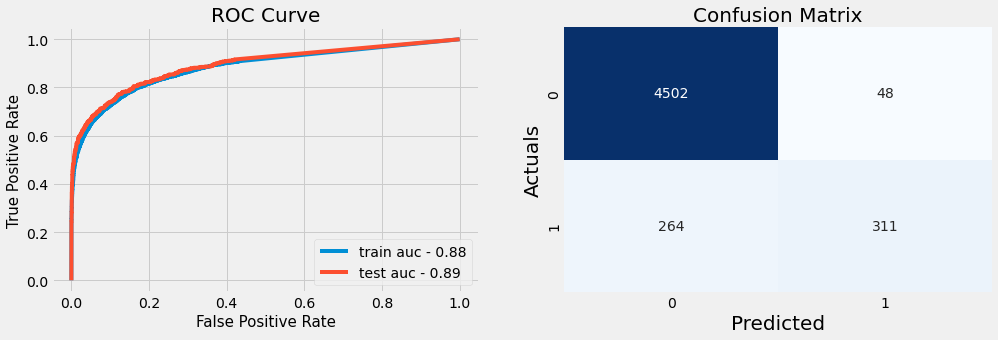

In [ ]:
model_nwlr_tfidf, scores_nwlr_tfidf = hyper_parameter_tuning('Non Weighted Logistic Regression Tfidf', nwlr_model,
                                                 nwlr_list,
                                                 X_train_tfidf_fs, X_valid_tfidf_fs, 
                                                 Y_train, Y_valid,
                                                 random=False)

Y_train_proba = model_nwlr_tfidf.predict_proba(X_train_tfidf_fs)
Y_valid_proba = model_nwlr_tfidf.predict_proba(X_valid_tfidf_fs)

Y_train_pred = model_nwlr_tfidf.predict(X_train_tfidf_fs)
Y_valid_pred = model_nwlr_tfidf.predict(X_valid_tfidf_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

**6.5 Decision Tree Classifier**

Trained started for : Decision Tree Classifier Count
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters:{'class_weight': 'balanced', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 10, 'random_state': 1}
Best Recall Score : 0.59

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.95      0.89      0.92      4550
           1       0.41      0.61      0.49       575

    accuracy                           0.86      5125
   macro avg       0.68      0.75      0.71      5125
weighted avg       0.89      0.86      0.87      5125



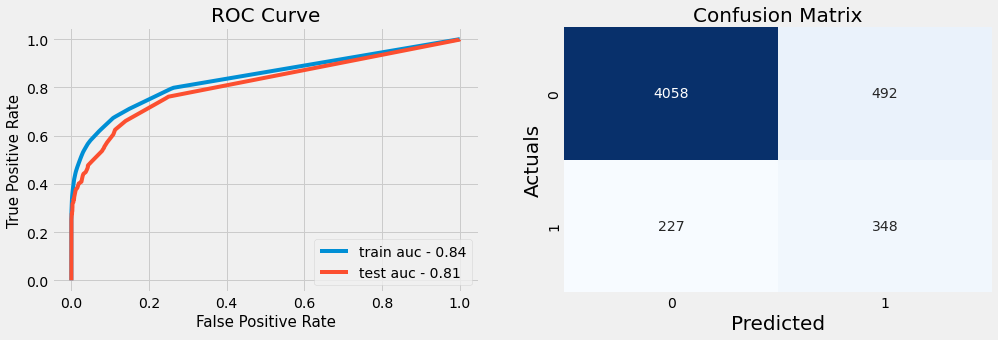

In [ ]:
dtc_list = {'max_depth': [5,6,7,8,9,10,11,12,13],
            'min_samples_split': [2, 5, 10], 
            'min_samples_leaf': [1, 2, 3],
            'class_weight' : ['balanced'],
            'random_state':[1]}

dtc_model = DecisionTreeClassifier()

model_dtc, scores_dtc = hyper_parameter_tuning('Decision Tree Classifier Count', dtc_model,
                                               dtc_list,
                                               X_train_count_fs, X_valid_count_fs, 
                                               Y_train, Y_valid,
                                               random=False)

Y_train_proba = model_dtc.predict_proba(X_train_count_fs)
Y_valid_proba = model_dtc.predict_proba(X_valid_count_fs)

Y_train_pred = model_dtc.predict(X_train_count_fs)
Y_valid_pred = model_dtc.predict(X_valid_count_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

Trained started for : Decision Tree Classifier Tfidf
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters:{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 1}
Best Recall Score : 0.59

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.95      0.88      0.91      4550
           1       0.40      0.61      0.48       575

    accuracy                           0.85      5125
   macro avg       0.67      0.75      0.70      5125
weighted avg       0.89      0.85      0.87      5125



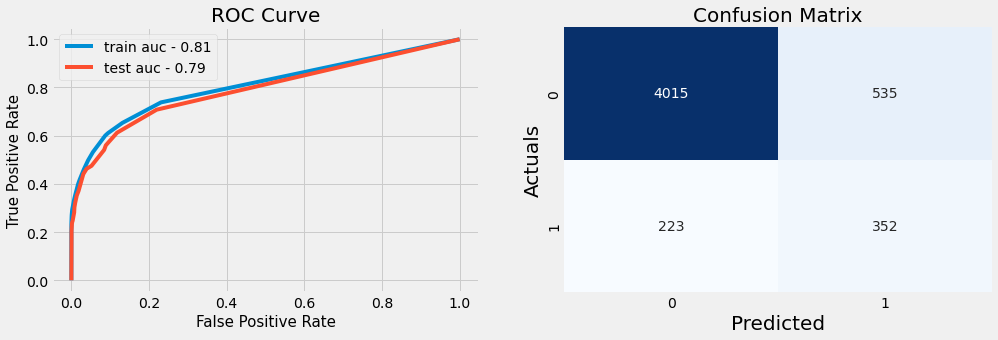

In [ ]:
model_dtc_tfidf, scores_dtc_tfidf = hyper_parameter_tuning('Decision Tree Classifier Tfidf', dtc_model,
                                               dtc_list,
                                               X_train_tfidf_fs, X_valid_tfidf_fs, 
                                               Y_train, Y_valid,
                                               random=False)

Y_train_proba = model_dtc_tfidf.predict_proba(X_train_tfidf_fs)
Y_valid_proba = model_dtc_tfidf.predict_proba(X_valid_tfidf_fs)

Y_train_pred = model_dtc_tfidf.predict(X_train_tfidf_fs)
Y_valid_pred = model_dtc_tfidf.predict(X_valid_tfidf_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

**6.6 Random Forest**

Trained started for : Random Forest Count
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:{'random_state': 1, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 12, 'class_weight': 'balanced', 'bootstrap': False}
Best Recall Score : 0.64

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.96      0.91      0.93      4550
           1       0.49      0.71      0.58       575

    accuracy                           0.88      5125
   macro avg       0.72      0.81      0.76      5125
weighted avg       0.91      0.88      0.89      5125



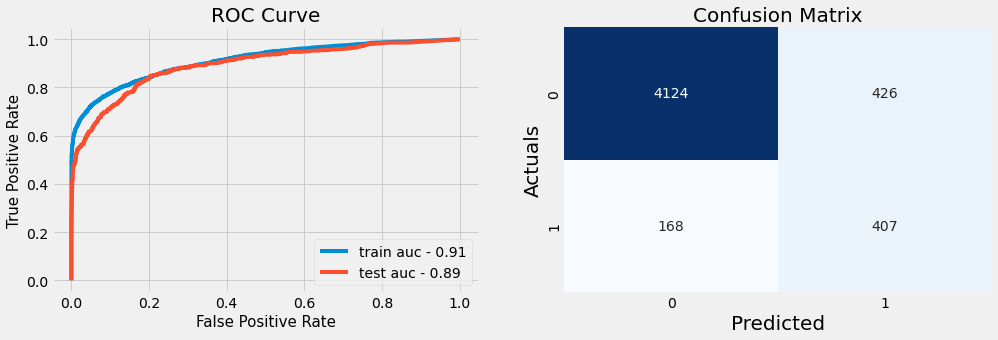

In [ ]:
rfc_list =  {'n_estimators': [100,200,300,400,500,600,700],
            'max_features': ['sqrt'],
            'max_depth': [5,6,7,8,9,10,11,12,13],
            'min_samples_split': [2, 5, 10], 
            'min_samples_leaf': [1, 2, 3],
            'bootstrap': [True, False],
            'class_weight' : ['balanced'],
            'random_state':[1]}

rfc_model = RandomForestClassifier()

model_rfc, scores_rfc = hyper_parameter_tuning('Random Forest Count', rfc_model, rfc_list, 
                                               X_train_count_fs, X_valid_count_fs, 
                                               Y_train, Y_valid,
                                               random=True)

Y_train_proba = model_rfc.predict_proba(X_train_count_fs)
Y_valid_proba = model_rfc.predict_proba(X_valid_count_fs)

Y_train_pred = model_rfc.predict(X_train_count_fs)
Y_valid_pred = model_rfc.predict(X_valid_count_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

Trained started for : Random Forest Tfidf
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:{'random_state': 1, 'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 13, 'class_weight': 'balanced', 'bootstrap': False}
Best Recall Score : 0.67

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.96      0.90      0.93      4550
           1       0.49      0.73      0.59       575

    accuracy                           0.88      5125
   macro avg       0.73      0.82      0.76      5125
weighted avg       0.91      0.88      0.89      5125



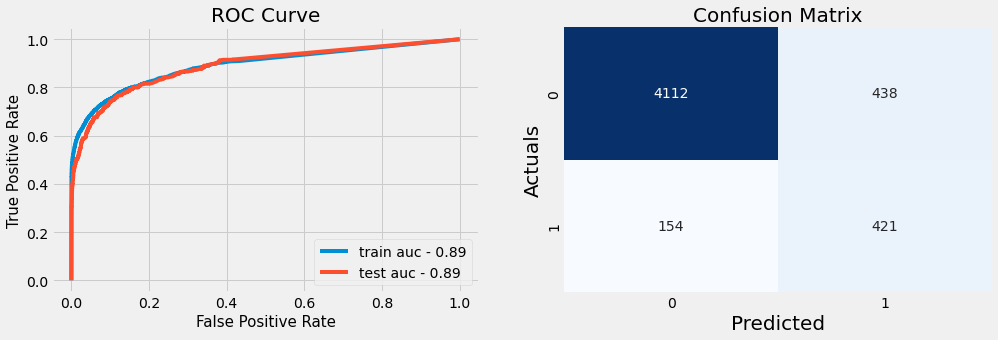

In [ ]:
model_rfc_tfidf, scores_rfc_tfidf = hyper_parameter_tuning('Random Forest Tfidf', rfc_model, rfc_list, 
                                               X_train_tfidf_fs, X_valid_tfidf_fs, 
                                               Y_train, Y_valid,
                                               random=True)

Y_train_proba = model_rfc_tfidf.predict_proba(X_train_tfidf_fs)
Y_valid_proba = model_rfc_tfidf.predict_proba(X_valid_tfidf_fs)

Y_train_pred = model_rfc_tfidf.predict(X_train_tfidf_fs)
Y_valid_pred = model_rfc_tfidf.predict(X_valid_tfidf_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

**6.7 Ada Boost Classifier**

Trained started for : Ada Boost Classifier Count
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:{'n_estimators': 500, 'learning_rate': 0.001}
Best Recall Score : 0.60

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.96      0.88      0.92      4550
           1       0.42      0.69      0.52       575

    accuracy                           0.86      5125
   macro avg       0.69      0.79      0.72      5125
weighted avg       0.90      0.86      0.87      5125



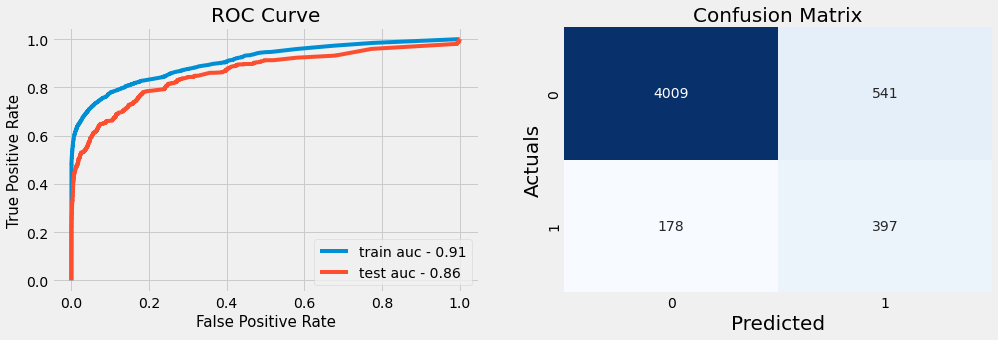

In [ ]:
abc_list = {'n_estimators' : [300, 500], 
            'learning_rate' : [0.001, 0.01, 0.1, 1, 10, 100]}

abc_model = AdaBoostClassifier(base_estimator = model_dtc)

model_abc, scores_abc = hyper_parameter_tuning('Ada Boost Classifier Count', abc_model,
                                               abc_list, 
                                               X_train_count_fs, X_valid_count_fs, 
                                               Y_train, Y_valid,
                                               random=True)

Y_train_proba = model_abc.predict_proba(X_train_count_fs)
Y_valid_proba = model_abc.predict_proba(X_valid_count_fs)

Y_train_pred = model_abc.predict(X_train_count_fs)
Y_valid_pred = model_abc.predict(X_valid_count_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

Trained started for : Ada Boost Classifier Tfidf
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:{'n_estimators': 500, 'learning_rate': 0.001}
Best Recall Score : 0.63

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

          -1       0.96      0.89      0.92      4550
           1       0.45      0.70      0.55       575

    accuracy                           0.87      5125
   macro avg       0.70      0.80      0.74      5125
weighted avg       0.90      0.87      0.88      5125



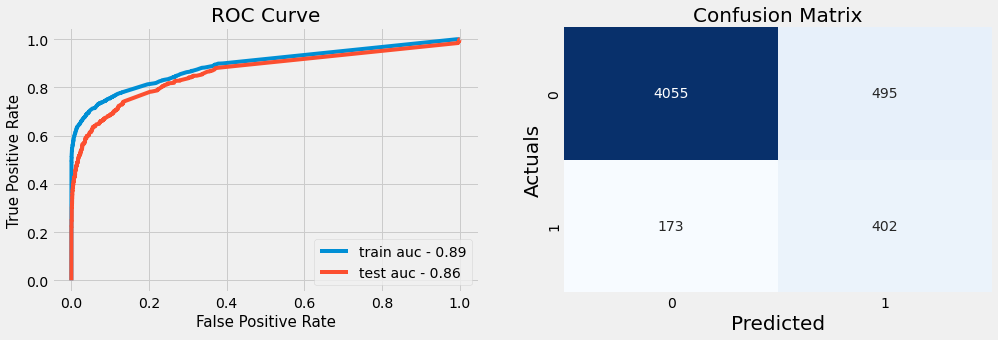

In [ ]:
model_abc_tfidf, scores_abc_tfidf = hyper_parameter_tuning('Ada Boost Classifier Tfidf', abc_model,
                                               abc_list, 
                                               X_train_tfidf_fs, X_valid_tfidf_fs, 
                                               Y_train, Y_valid,
                                               random=True)

Y_train_proba = model_abc_tfidf.predict_proba(X_train_tfidf_fs)
Y_valid_proba = model_abc_tfidf.predict_proba(X_valid_tfidf_fs)

Y_train_pred = model_abc_tfidf.predict(X_train_tfidf_fs)
Y_valid_pred = model_abc_tfidf.predict(X_valid_tfidf_fs)

get_plots(Y_train, Y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

**6.8 XGBOOST**

Trained started for : XGBOOST Count
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:{'n_estimators': 300, 'min_child_weight': 0.2, 'max_depth': 5, 'lambda': 1.0, 'gamma': 0.4, 'colsample_bytree': 0.3}
Best Recall Score : 0.47

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4550
           1       0.86      0.57      0.68       575

    accuracy                           0.94      5125
   macro avg       0.90      0.78      0.82      5125
weighted avg       0.94      0.94      0.94      5125



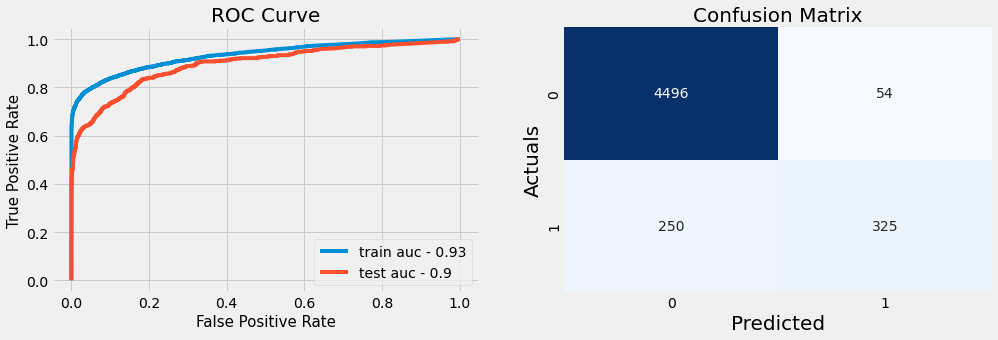

In [ ]:
param_values = [i/10 for i in range(1, 11, 1)]
xgb_list = {'max_depth' : range(3,18),
            'gamma' : param_values,
            'colsample_bytree' : param_values,
            'lambda' : param_values,
            'n_estimators' : [50, 100, 150, 200, 250, 300],
            'min_child_weight' : param_values}

y_train = Y_train.map({-1 : 0, 1 : 1})
y_valid = Y_valid.map({-1 : 0, 1 : 1})

xgb_model = xgb.XGBClassifier(random_state = 1, nthread = -1, n_jobs = -1)

model_xgb, scores_xgb = hyper_parameter_tuning('XGBOOST Count', xgb_model,
                                               xgb_list,
                                               X_train_count_fs, X_valid_count_fs, 
                                               y_train,
                                               y_valid,
                                               random=True)

Y_train_proba = model_xgb.predict_proba(X_train_count_fs)
Y_valid_proba = model_xgb.predict_proba(X_valid_count_fs)

Y_train_pred = model_xgb.predict(X_train_count_fs)
Y_valid_pred = model_xgb.predict(X_valid_count_fs)

get_plots(y_train, y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

Trained started for : XGBOOST Tfidf
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:{'n_estimators': 200, 'min_child_weight': 0.3, 'max_depth': 15, 'lambda': 0.7, 'gamma': 1.0, 'colsample_bytree': 0.4}
Best Recall Score : 0.49

-------------------------------------Classification Report---------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4550
           1       0.82      0.58      0.68       575

    accuracy                           0.94      5125
   macro avg       0.88      0.78      0.82      5125
weighted avg       0.93      0.94      0.93      5125



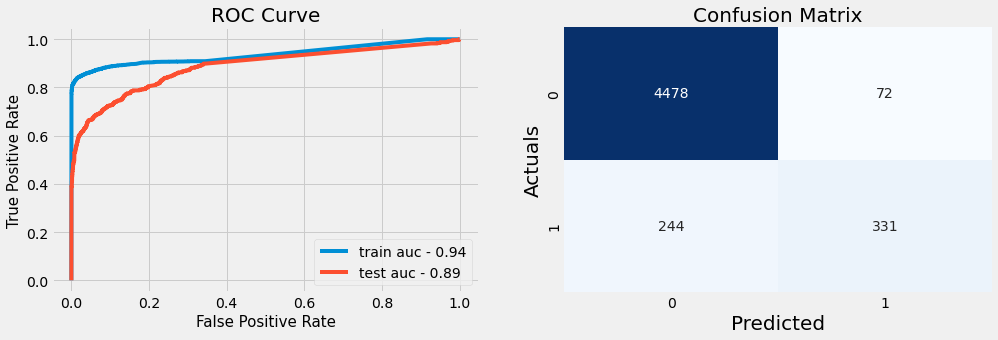

In [ ]:
model_xgb_tfidf, scores_xgb_tfidf = hyper_parameter_tuning('XGBOOST Tfidf', xgb_model,
                                               xgb_list,
                                               X_train_tfidf_fs, X_valid_tfidf_fs, 
                                               y_train,
                                               y_valid,
                                               random=True)

Y_train_proba = model_xgb_tfidf.predict_proba(X_train_tfidf_fs)
Y_valid_proba = model_xgb_tfidf.predict_proba(X_valid_tfidf_fs)

Y_train_pred = model_xgb_tfidf.predict(X_train_tfidf_fs)
Y_valid_pred = model_xgb_tfidf.predict(X_valid_tfidf_fs)

get_plots(y_train, y_valid,
          Y_train_proba, Y_valid_proba,
          Y_train_pred, Y_valid_pred)

**7. Output Comparison**

In [ ]:
final_scores = pd.DataFrame()

final_scores = final_scores.append(scores_gnb,       ignore_index=True)
final_scores = final_scores.append(scores_gnb_tfidf, ignore_index=True)

final_scores = final_scores.append(scores_bnb,       ignore_index=True)
final_scores = final_scores.append(scores_bnb_tfidf, ignore_index=True)

final_scores = final_scores.append(scores_wlr,       ignore_index=True)
final_scores = final_scores.append(scores_wlr_tfidf, ignore_index=True)

final_scores = final_scores.append(scores_nwlr,      ignore_index=True)
final_scores = final_scores.append(scores_nwlr_tfidf,ignore_index=True)

final_scores = final_scores.append(scores_dtc,       ignore_index=True)
final_scores = final_scores.append(scores_dtc_tfidf, ignore_index=True)

final_scores = final_scores.append(scores_rfc,       ignore_index=True)
final_scores = final_scores.append(scores_rfc_tfidf, ignore_index=True)

final_scores = final_scores.append(scores_abc,       ignore_index=True)
final_scores = final_scores.append(scores_abc_tfidf, ignore_index=True)

final_scores = final_scores.append(scores_xgb,       ignore_index=True)
final_scores = final_scores.append(scores_xgb_tfidf, ignore_index=True)

final_scores['vectorizer'] = final_scores['model_name'].apply(lambda x :
                                                              'count_vetorizer' if 
                                                              'Count' in x
                                                              else 'tfidf_vectorizer')

In [ ]:
## dump data
final_scores.to_csv(os.path.join(FOLDER_PATH, 'model_output_scores.csv'), index=False)

In [ ]:
## get sorted rows to select best model
final_scores.sort_values(by = ['propaganda_accuracy', 'recall'],
                         ascending=False)

,model_name,accuracy,auc,not_propaganda_accuracy,propaganda_accuracy,f1,precision,recall,roc,vectorizer
5,Weighted Logistic Regression Tfidf,0.8921,0.8922,0.9123,0.7322,0.6036,0.5134,0.7322,0.8222,tfidf_vectorizer
11,Random Forest Tfidf,0.8845,0.8880,0.9037,0.7322,0.5872,0.4901,0.7322,0.8180,tfidf_vectorizer
10,Random Forest Count,0.8841,0.8927,0.9064,0.7078,0.5781,0.4886,0.7078,0.8071,count_vetorizer
4,Weighted Logistic Regression Count,0.8968,0.8915,0.9213,0.7026,0.6043,0.5302,0.7026,0.8120,count_vetorizer
13,Ada Boost Classifier Tfidf,0.8697,0.8619,0.8912,0.6991,0.5462,0.4482,0.6991,0.7952,tfidf_vectorizer
12,Ada Boost Classifier Count,0.8597,0.8604,0.8811,0.6904,0.5248,0.4232,0.6904,0.7858,count_vetorizer
9,Decision Tree Classifier Tfidf,0.8521,0.7898,0.8824,0.6122,0.4815,0.3968,0.6122,0.7473,tfidf_vectorizer
8,Decision Tree Classifier Count,0.8597,0.8107,0.8919,0.6052,0.4919,0.4143,0.6052,0.7485,count_vetorizer
15,XGBOOST Tfidf,0.9383,0.8851,0.9842,0.5757,0.6769,0.8213,0.5757,0.7799,tfidf_vectorizer
14,XGBOOST Count,0.9407,0.8957,0.9881,0.5652,0.6813,0.8575,0.5652,0.7767,count_vetorizer


**Best Model Selection**


1. The best model is - **weighted logistic regression**
2. encoding type - tfidf vectorizer
3. It has highest recall score along with highest propaganda accuracy score amongst all of them.
4. As the actual dataset was imbalance the model output should complient the minority class properly and should generate high recall along with balanced f1 score.
5. Also the best selected model is fitting best with an validation AUC score of 89% and overall accuracy of 90%.